<a href="https://colab.research.google.com/github/WhiteTeaDragon/SingularValues/blob/main/Performance_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for ResNet copied from https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

### Functions

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, Regularizer
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

In [55]:
import time

def tensorflow_method128(kernel, n1, n2):
    start = time.time()
    print(kernel.shape)
    conv_tr = tf.cast(tf.transpose(kernel, perm=[2, 3, 0, 1]), tf.complex64)
    print("after cast", time.time() - start)
    transforms = tf.transpose(
        tf.signal.fft2d(
            tf.pad(
                conv_tr, ((0, 0), (0, 0), (0, n1 - kernel.shape[0]),
                                (0, n2 - kernel.shape[0]))
            )
        ), 
        perm=[2, 3, 0, 1]
    )
    print("before svd", time.time() - start)
    return tf.linalg.svd(transforms, compute_uv=False)

In [80]:
# better not to use it, works really long
class MyRegularizer(Regularizer):
    def __init__(self, n1, n2):
        self.n1 = n1
        self.n2 = n2
        self.cnt = 0

    def __call__(self, x):
        self.cnt += 1
        print(self.cnt)
        if self.cnt == 1:
          self.cnt = 0
          return tf.reduce_sum(tf.square(tensorflow_method128(x, self.n1, self.n2)))
    
    def get_config(self):
        return {'n1': self.n1, 'n2': self.n2, 'cnt': self.cnt}

In [20]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [21]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 singular_reg=False):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    if not singular_reg:
        conv = Conv2D(num_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(1e-4))
    else:
        conv = Conv2D(num_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=MyRegularizer(inputs.shape[1], inputs.shape[2]))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [22]:
def resnet_v1(input_shape, depth, num_classes=10, singular_reg=False):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, singular_reg=singular_reg)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides, singular_reg=singular_reg)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None, singular_reg=singular_reg)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False,
                                 singular_reg=singular_reg)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [23]:
def resnet_v2(input_shape, depth, num_classes=10, singular_reg=False):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True, singular_reg=singular_reg)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False,
                             singular_reg=singular_reg)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False,
                             singular_reg=singular_reg)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False,
                             singular_reg=singular_reg)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False,
                                 singular_reg=singular_reg)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
def define_and_compile_ResNet_model(version=1, depth=32, singular_reg=False):
    # model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)
    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth,
                          singular_reg=singular_reg)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth,
                          singular_reg=singular_reg)

    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=lr_schedule(0)),
                metrics=['acc'])
    return model, model_type

In [25]:
# prepare model saving directory.
def prepare_model_saving_directory(model_type):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    return filepath

In [26]:
# prepare callbacks for model saving and for learning rate adjustment.
def standard_callbacks(model_type):
    checkpoint = ModelCheckpoint(filepath=prepare_model_saving_directory(model_type),
                                monitor='val_acc',
                                verbose=1,
                                save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown=0,
                                patience=5,
                                min_lr=0.5e-6)

    return [checkpoint, lr_reducer, lr_scheduler]

In [28]:
import pickle

# run training, with or without data augmentation.
def run_training(model, model_type, x_train, y_train, x_test, y_test,
                 history_file_dump_name,
                 steps_per_epoch=None,
                 batch_size=128, epochs=250, data_augmentation=True,
                 callbacks=None):
    if steps_per_epoch is None:
        steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    if callbacks is None:
        callbacks = standard_callbacks(model_type)
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True,
                steps_per_epoch=steps_per_epoch,
                callbacks=standard_callbacks(model_type))
    else:
        print('Using real-time data augmentation.')
        # this will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False)

        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        
        # fit the model on the batches generated by datagen.flow().
        history = model.fit(x=datagen.flow(x_train, y_train,
                                           batch_size=batch_size),
                verbose=1,
                epochs=epochs,
                validation_data=(x_test, y_test),
                steps_per_epoch=steps_per_epoch,
                callbacks=callbacks)
    file_pi = open(history_file_dump_name, 'wb')
    pickle.dump(history.history, file_pi)
    file_pi.close()
    return history

In [65]:
def Clip_OperatorNorm(conv, inp_shape, clip_to):
  conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex128)
  conv_shape = conv.get_shape().as_list()
  padding = tf.constant([[0, 0], [0, 0],
                         [0, inp_shape[0] - conv_shape[0]],
                         [0, inp_shape[1] - conv_shape[1]]])
  transform_coeff = tf.signal.fft2d(tf.pad(conv_tr, padding))
  D, U, V = tf.linalg.svd(tf.transpose(transform_coeff, perm = [2, 3, 0, 1]))
  norm = tf.reduce_max(D)
  D_clipped = tf.cast(tf.minimum(D, clip_to), tf.complex128)
  clipped_coeff = tf.matmul(U, tf.matmul(tf.linalg.diag(D_clipped),
                                         V, adjoint_b=True))
  clipped_conv_padded = tf.math.real(tf.signal.ifft2d(
      tf.transpose(clipped_coeff, perm=[2, 3, 0, 1])))
  return tf.slice(tf.transpose(clipped_conv_padded, perm=[2, 3, 0, 1]),
                  [0] * len(conv_shape), conv_shape), norm

In [120]:
import keras.backend as K
from keras.callbacks import LambdaCallback
import copy

def afterEpochClipTo05(epochs, logs):
    for layer in model.layers:
        if layer.name[:6] == "conv2d":
            K.set_value(layer.kernel, Clip_OperatorNorm(layer.kernel,
                                                        layer.input_shape[1:3],
                                                        0.5)[0])
            
def afterEpochClipTo1(epochs, logs):
    for layer in model.layers:
        if layer.name[:6] == "conv2d":
            K.set_value(layer.kernel, Clip_OperatorNorm(layer.kernel,
                                                        layer.input_shape[1:3],
                                                        1.0)[0])

In [96]:
from matplotlib import pyplot as plt
import numpy as np

def plot_loss_acc(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].grid(True)
    axs[1].grid(True)
    axs[0].plot(history['loss'], label='train')
    axs[0].plot(history['val_loss'], label='val')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylim(0, 2)
    axs[1].plot(1 - np.array(history['acc']), label='train')
    axs[1].plot(1 - np.array(history['val_acc']), label='val')
    axs[1].set_title('Error')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylim(0, 0.4)
    axs[0].legend(loc='best')
    axs[1].legend(loc='best')

### Loading Data

In [31]:
num_classes = 10

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------


# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


### Model without clipping

In [100]:
model, model_type = define_and_compile_ResNet_model()

# enable this if pydot can be installed
# plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
# print(model_type)

model.summary()

Learning rate:  0.001
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_363 (Conv2D)             (None, 32, 32, 16)   448         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_341 (BatchN (None, 32, 32, 16)   64          conv2d_363[0][0]                 
__________________________________________________________________________________________________
activation_341 (Activation)     (None, 32, 32, 16)   0           batch_normalization_341[0][0]    
_____________________________________________________________________

In [101]:
history = run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'trainHistoryDict', steps_per_epoch=100, epochs=250)

Using real-time data augmentation.
Epoch 1/250
Learning rate:  0.001
100/100 [==============================] - 12s 92ms/step - loss: 2.8730 - acc: 0.2339 - val_loss: 2.6847 - val_acc: 0.1900

Epoch 00001: val_acc improved from -inf to 0.19000, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/250
Learning rate:  0.001
100/100 [==============================] - 8s 81ms/step - loss: 1.7984 - acc: 0.4292 - val_loss: 2.6166 - val_acc: 0.1782

Epoch 00002: val_acc did not improve from 0.19000
Epoch 3/250
Learning rate:  0.001
100/100 [==============================] - 8s 82ms/step - loss: 1.6379 - acc: 0.4905 - val_loss: 1.7994 - val_acc: 0.4398

Epoch 00003: val_acc improved from 0.19000 to 0.43980, saving model to /content/saved_models/cifar10_ResNet32v1_model.003.h5
Epoch 4/250
Learning rate:  0.001
100/100 [==============================] - 8s 81ms/step - loss: 1.5362 - acc: 0.5300 - val_loss: 2.0058 - val_acc: 0.4026

Epoch 00004: val_acc did not improve fr

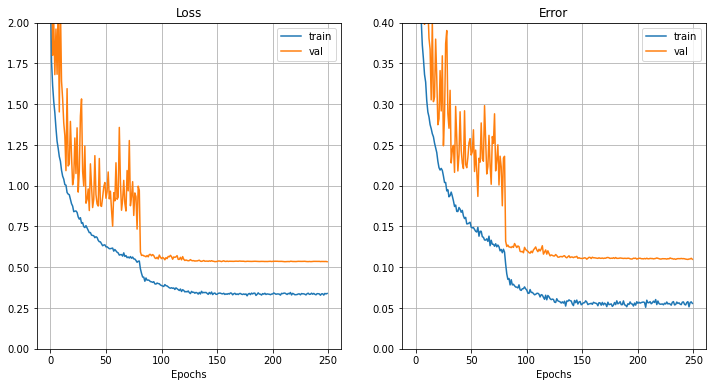

In [102]:
import pickle

history = pickle.load(open('trainHistoryDict', "rb"))
plot_loss_acc(history)

In [103]:
1 - history['val_acc'][-1]

0.10979998111724854

### Model with clipping to 0.5

In [86]:
model, model_type = define_and_compile_ResNet_model()

# enable this if pydot can be installed
# plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
# print(model_type)

model.summary()

Learning rate:  0.001
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_330 (Conv2D)             (None, 32, 32, 16)   448         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_310 (BatchN (None, 32, 32, 16)   64          conv2d_330[0][0]                 
__________________________________________________________________________________________________
activation_310 (Activation)     (None, 32, 32, 16)   0           batch_normalization_310[0][0]    
_____________________________________________________________________

In [88]:
singular_values_clipping = LambdaCallback(on_epoch_end = afterEpochClipTo05)
callbacks = standard_callbacks(model_type) + [singular_values_clipping]

In [89]:
history = run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'trainHistoryDict_clip_05', steps_per_epoch=100, epochs=250,
                       callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/250
Learning rate:  0.001
100/100 [==============================] - 12s 91ms/step - loss: 2.6063 - acc: 0.2643 - val_loss: 2.3301 - val_acc: 0.2673

Epoch 00001: val_acc improved from -inf to 0.26730, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/250
Learning rate:  0.001
100/100 [==============================] - 8s 82ms/step - loss: 1.9281 - acc: 0.2893 - val_loss: 2.9392 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.26730
Epoch 3/250
Learning rate:  0.001
100/100 [==============================] - 8s 82ms/step - loss: 1.6299 - acc: 0.4081 - val_loss: 3.6542 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.26730
Epoch 4/250
Learning rate:  0.001
100/100 [==============================] - 8s 85ms/step - loss: 1.4266 - acc: 0.4920 - val_loss: 3.9285 - val_acc: 0.1553

Epoch 00004: val_acc did not improve from 0.26730
Epoch 5/250
Learning rate:  0.001
100/100 [=====================

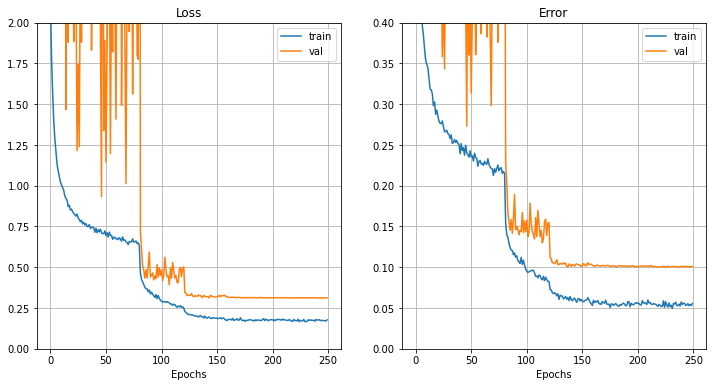

In [98]:
import pickle

history = pickle.load(open('trainHistoryDict_clip_05', "rb"))
plot_loss_acc(history)

In [99]:
1 - history['val_acc'][-1]

0.10089999437332153

### Model with clipping to 1.0

In [104]:
model, model_type = define_and_compile_ResNet_model()

# enable this if pydot can be installed
# plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
# print(model_type)

model.summary()

Learning rate:  0.001
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_396 (Conv2D)             (None, 32, 32, 16)   448         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_372 (BatchN (None, 32, 32, 16)   64          conv2d_396[0][0]                 
__________________________________________________________________________________________________
activation_372 (Activation)     (None, 32, 32, 16)   0           batch_normalization_372[0][0]    
_____________________________________________________________________

In [106]:
singular_values_clipping = LambdaCallback(on_epoch_end = afterEpochClipTo1)
callbacks = standard_callbacks(model_type) + [singular_values_clipping]

In [107]:
history = run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'trainHistoryDict_clip_1', steps_per_epoch=100, epochs=250,
                       callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/250
Learning rate:  0.001
100/100 [==============================] - 12s 91ms/step - loss: 3.2535 - acc: 0.2539 - val_loss: 2.6328 - val_acc: 0.2073

Epoch 00001: val_acc improved from -inf to 0.20730, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/250
Learning rate:  0.001
100/100 [==============================] - 8s 80ms/step - loss: 1.7636 - acc: 0.3840 - val_loss: 3.7335 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.20730
Epoch 3/250
Learning rate:  0.001
100/100 [==============================] - 8s 79ms/step - loss: 1.4934 - acc: 0.4833 - val_loss: 4.6673 - val_acc: 0.1110

Epoch 00003: val_acc did not improve from 0.20730
Epoch 4/250
Learning rate:  0.001
100/100 [==============================] - 8s 80ms/step - loss: 1.3222 - acc: 0.5528 - val_loss: 2.6482 - val_acc: 0.2707

Epoch 00004: val_acc improved from 0.20730 to 0.27070, saving model to /content/saved_models/cifar10_ResNet32v1_mo

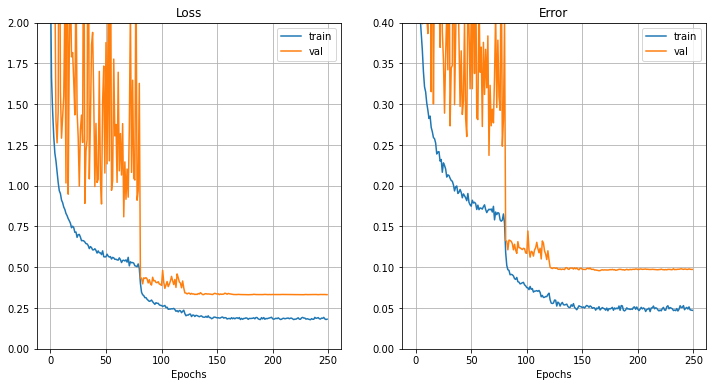

In [111]:
import pickle

history = pickle.load(open('trainHistoryDict_clip_1', "rb"))
plot_loss_acc(history)

In [112]:
1 - history['val_acc'][-1]

0.0974000096321106

### Plotting final graph

In [113]:
history_no_clipping = pickle.load(open('trainHistoryDict', "rb"))
history_05 = pickle.load(open('trainHistoryDict_clip_05', "rb"))
history_1 = pickle.load(open('trainHistoryDict_clip_1', "rb"))

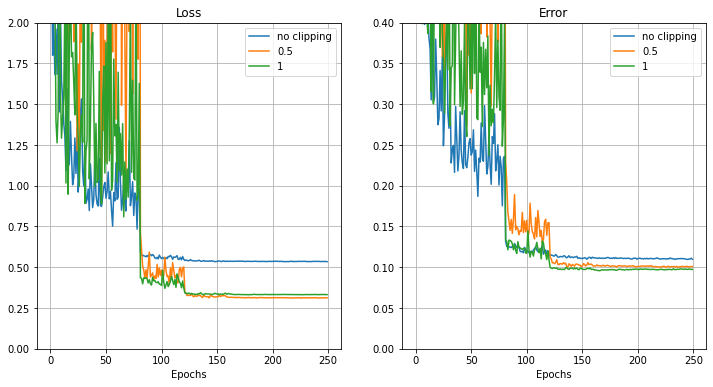

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].grid(True)
axs[1].grid(True)
axs[0].plot(history_no_clipping['val_loss'], label='no clipping')
axs[0].plot(history_05['val_loss'], label='0.5')
axs[0].plot(history_1['val_loss'], label='1')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylim(0, 2)
axs[1].plot(1 - np.array(history_no_clipping['val_acc']), label='no clipping')
axs[1].plot(1 - np.array(history_05['val_acc']), label='0.5')
axs[1].plot(1 - np.array(history_1['val_acc']), label='1')
axs[1].set_title('Error')
axs[1].set_xlabel('Epochs')
axs[1].set_ylim(0, 0.4)
axs[0].legend(loc='best')
axs[1].legend(loc='best')